Adapted from https://github.com/lightly-ai/lightly/blob/master/docs/source/getting_started/benchmarks/imagenette_benchmark.py

| Model         | Batch Size | Epochs |  KNN Test Accuracy |       Time | Peak GPU Usage |
|---------------|------------|--------|--------------------|------------|----------------|
| BarlowTwins   |        256 |    200 |              0.587 |   86.2 Min |      4.0 GByte |
| BYOL          |        256 |    200 |              0.619 |   88.6 Min |      4.3 GByte |
| DCL (*)       |        256 |    200 |              0.762 |   53.3 Min |      4.3 GByte |
| DCLW (*)      |        256 |    200 |              0.755 |   53.7 Min |      4.3 GByte |
| DINO (Res18)  |        256 |    200 |              0.736 |   86.5 Min |      4.1 GByte |
| MSN (ViT-S)   |        256 |    200 |              0.741 |   92.7 Min |     16.3 GByte |
| Moco          |        256 |    200 |              0.727 |   87.3 Min |      4.3 GByte |
| NNCLR         |        256 |    200 |              0.726 |   86.8 Min |      4.2 GByte |
| SimCLR        |        256 |    200 |              0.771 |   82.2 Min |      3.9 GByte |
| SimSiam       |        256 |    200 |              0.669 |   78.6 Min |      3.9 GByte |
| SMoG          |        128 |    200 |              0.698 |  220.9 Min |     14.3 GByte |
| SwaV          |        256 |    200 |              0.748 |   77.6 Min |      4.0 GByte |
|---------------|------------|--------|--------------------|------------|----------------|
| BarlowTwins   |        256 |    800 |              0.789 |  330.9 Min |      4.0 GByte |
| BYOL          |        256 |    800 |              0.851 |  332.7 Min |      4.3 GByte |
| DCL (*)       |        256 |    800 |              0.816 |  213.1 Min |      4.3 GByte |
| DCLW (*)      |        256 |    800 |              0.827 |  213.1 Min |      4.3 GByte |
| DINO (Res18)  |        256 |    800 |              0.881 |  613.9 Min |      6.7 GByte |
| MSN (ViT-S)   |        256 |    800 |              0.834 |  376.1 Min |     16.3 GByte |
| Moco          |        256 |    800 |              0.832 |  322.8 Min |      4.2 GByte |
| NNCLR         |        256 |    800 |              0.848 |  341.4 Min |      4.2 GByte |
| SimCLR        |        256 |    800 |              0.858 |  324.8 Min |      3.9 GByte |
| SimSiam       |        256 |    800 |              0.852 |  316.0 Min |      3.9 GByte |
| SwaV          |        256 |    800 |              0.899 |  554.7 Min |      6.6 GByte |

In [4]:
from timm.models._registry import register_model

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from torch.hub import load
backbone = load("facebookresearch/dino:main", "dino_vits16", pretrained=False)

Using cache found in C:\Users\khanm/.cache\torch\hub\facebookresearch_dino_main


In [1]:
import copy
import math
import time
import warnings

import lightly
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import timm
import torch
import torch.nn as nn
import torchvision
from lightly.data import LightlyDataset
from lightly.data.collate import MultiViewCollateFunction, SimCLRCollateFunction
from lightly.loss import NegativeCosineSimilarity
from lightly.models import modules, utils
from lightly.models.modules import heads, masked_autoencoder
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchmetrics.classification import (
    Accuracy,
    MulticlassAccuracy,
    MulticlassAUROC,
    MulticlassF1Score,
)
from torchmetrics.functional.classification import (
    multiclass_accuracy,
    multiclass_f1_score,
)
from utilities.benchmarking import KNNBenchmarkModule
from utilities.data import *

# suppress annoying torchmetrics and lightning warnings
warnings.filterwarnings("ignore", ".*interpolation.*")
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*meaningless.*")
warnings.filterwarnings("ignore", ".*log_every_n_steps.*")

In [2]:
logs_root_dir = os.path.join(os.getcwd(), "benchmark_logs")

num_workers = os.cpu_count()
memory_bank_size = 4096

# set max_epochs to 800 for long run (takes around 10h on a single V100)
max_epochs = 5
knn_k = 200
knn_t = 0.1
classes = 9
input_size = 200

#  Set to True to enable Distributed Data Parallel training.
distributed = False

# Set to True to enable Synchronized Batch Norm (requires distributed=True).
# If enabled the batch norm is calculated over all gpus, otherwise the batch
# norm is only calculated from samples on the same gpu.
sync_batchnorm = False

# Set to True to gather features from all gpus before calculating
# the loss (requires distributed=True).
#  If enabled then the loss on every gpu is calculated with features from all
# gpus, otherwise only features from the same gpu are used.
gather_distributed = False

# benchmark
n_runs = 3  # optional, increase to create multiple runs and report mean + std
batch_size = 32
lr_factor = batch_size / 256  #  scales the learning rate linearly with batch size

# use a GPU if available
gpus = torch.cuda.device_count() if torch.cuda.is_available() else 0

if distributed:
    distributed_backend = "ddp"
    # reduce batch size for distributed training
    batch_size = batch_size // gpus
else:
    distributed_backend = None
    # limit to single gpu if not using distributed training
    gpus = min(gpus, 1)

In [8]:
df = pd.read_pickle("../data/cleaned_splits/train_29_split.pkl")
X_train, X_val, y_train, y_val = train_test_split(df.waferMap, df.failureCode, test_size=0.25, random_state=42)

dataset_train_ssl = LightlyDataset.from_torch_dataset(
    WaferMapDataset(X_train, y_train)
)

# we use test transformations for getting the feature for kNN on train data
dataset_train_kNN = LightlyDataset.from_torch_dataset(
    WaferMapDataset(X_train, y_train), transform=get_inference_transforms()
)

dataset_test = LightlyDataset.from_torch_dataset(
    WaferMapDataset(X_val, y_val), transform=get_inference_transforms()
)

,count,fraction
8,8007,0.591446
3,2112,0.156005
2,1099,0.081179
0,917,0.067735
4,791,0.058428
7,271,0.020018
6,193,0.014256
1,116,0.008568
5,32,0.002364


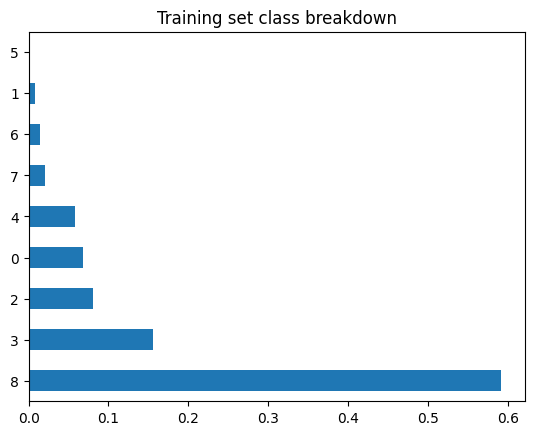

,count,fraction
8,2644,0.585863
3,695,0.154000
2,406,0.089962
0,328,0.072679
4,251,0.055617
7,75,0.016619
6,58,0.012852
1,45,0.009971
5,11,0.002437


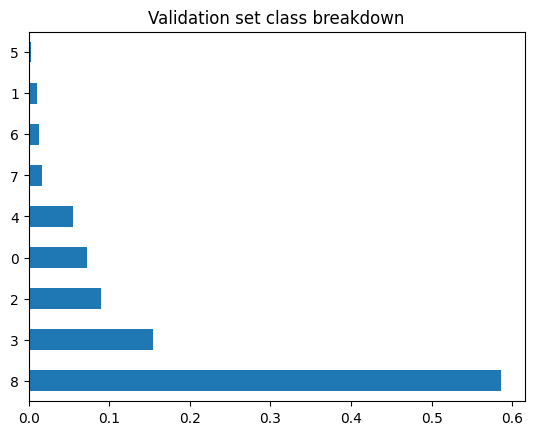

In [9]:
import matplotlib.pyplot as plt

def show_breakdown(series, title=None):
    """
    Given a pandas Series, displays value_counts(), both raw counts and normalized.
    Also plots a horizontal bar chart of normalized value counts.
    """
    breakdown = pd.concat(
        [series.value_counts(), series.value_counts(normalize=True)],
        axis=1,
        keys=("count", "fraction")
    )
    display(breakdown)
    breakdown.fraction.plot(kind="barh")
    if title:
        plt.title(title)
    plt.show()

show_breakdown(y_train, "Training set class breakdown")
show_breakdown(y_val, "Validation set class breakdown")

In [ ]:
# Base collate function for basic joint embedding
# e.g. SimCLR, MoCo, BYOL, Barlow Twins, or SimSiam
collate_fn = WaferImageCollateFunction([input_size, input_size])

# Multi crop augmentation for DINO
dino_collate_fn = WaferDINOCOllateFunction(
    global_crop_size=input_size, local_crop_size=input_size // 2
)

fastsiam_collate_fn = WaferFastSiamCollateFunction([input_size, input_size])

# Multi crop augmentation for MSN
msn_collate_fn = WaferMSNCollateFunction(
    random_size=input_size, focal_size=input_size // 2
)

In [ ]:
# from lightly.utils.debug import plot_augmented_images, std_of_l2_normalized

# plot_augmented_images(
#     # Grab 5 random samples from X_train to visualize original and augmented images for each
#     X_train.sample(5).tolist(),
#     collate_fn,
# );

In [ ]:
def get_data_loaders(batch_size: int, model):
    """Helper method to create dataloaders for ssl, kNN train and kNN test

    Args:
        batch_size: Desired batch size for all dataloaders
    """
    col_fn = collate_fn
    # if the model is any of the DINO models, we use the DINO collate function
    if (
        model == DINOModel
        or model == DINOConvNeXtModel
        or model == DINOXCiTModel
        or model == DINOViTModel
        or model == DINOSWINModel
    ):
        col_fn = dino_collate_fn
    elif model == MSNModel:
        col_fn = msn_collate_fn
    elif model == FastSiamModel:
        col_fn = fastsiam_collate_fn

    dataloader_train_ssl = DataLoader(
        dataset_train_ssl,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=col_fn,
        drop_last=True,
        # num_workers=num_workers,
    )

    dataloader_train_kNN = DataLoader(
        dataset_train_kNN,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        # num_workers=num_workers,
    )

    dataloader_test = DataLoader(
        dataset_test,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        # num_workers=num_workers,
    )

    return dataloader_train_ssl, dataloader_train_kNN, dataloader_test


class MocoModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)

        # create a ResNet backbone and remove the classification head
        num_splits = 0 if sync_batchnorm else 8
        # # TODO: Add split batch norm to the resnet model
        # resnet = torchvision.models.resnet18()
        # feature_dim = list(resnet.children())[-1].in_features
        # self.backbone = nn.Sequential(
        #     *list(resnet.children())[:-1], nn.AdaptiveAvgPool2d(1)
        # )

        self.backbone = timm.create_model("resnet18", num_classes=0)
        feature_dim = timm.create_model("resnet18").get_classifier().in_features

        # create a moco model based on ResNet
        self.projection_head = heads.MoCoProjectionHead(feature_dim, 2048, 128)
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)
        utils.deactivate_requires_grad(self.backbone_momentum)
        utils.deactivate_requires_grad(self.projection_head_momentum)

        # create our loss with the optional memory bank
        self.criterion = lightly.loss.NTXentLoss(
            temperature=0.1, memory_bank_size=memory_bank_size
        )

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        return self.projection_head(x)

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch

        # update momentum
        utils.update_momentum(self.backbone, self.backbone_momentum, 0.99)
        utils.update_momentum(self.projection_head, self.projection_head_momentum, 0.99)

        def step(x0_, x1_):
            x1_, shuffle = utils.batch_shuffle(x1_, distributed=distributed)
            x0_ = self.backbone(x0_).flatten(start_dim=1)
            x0_ = self.projection_head(x0_)

            x1_ = self.backbone_momentum(x1_).flatten(start_dim=1)
            x1_ = self.projection_head_momentum(x1_)
            x1_ = utils.batch_unshuffle(x1_, shuffle, distributed=distributed)
            return x0_, x1_

        # We use a symmetric loss (model trains faster at little compute overhead)
        # https://colab.research.google.com/github/facebookresearch/moco/blob/colab-notebook/colab/moco_cifar10_demo.ipynb
        loss_1 = self.criterion(*step(x0, x1))
        loss_2 = self.criterion(*step(x1, x0))

        loss = 0.5 * (loss_1 + loss_2)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        params = list(self.backbone.parameters()) + list(
            self.projection_head.parameters()
        )
        optim = torch.optim.SGD(
            params,
            lr=6e-2 * lr_factor,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


class SimCLRModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)
        # create a ResNet backbone and remove the classification head
        # resnet = torchvision.models.resnet18()
        # feature_dim = list(resnet.children())[-1].in_features
        # self.backbone = nn.Sequential(
        #     *list(resnet.children())[:-1], nn.AdaptiveAvgPool2d(1)
        # )

        self.backbone = timm.create_model("resnet18", num_classes=0)
        feature_dim = timm.create_model("resnet18").get_classifier().in_features
        self.projection_head = heads.SimCLRProjectionHead(feature_dim, feature_dim, 128)
        self.criterion = lightly.loss.NTXentLoss()

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2 * lr_factor, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


class SimSiamModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)
        # create a ResNet backbone and remove the classification head
        # resnet = torchvision.models.resnet18()
        # feature_dim = list(resnet.children())[-1].in_features
        # self.backbone = nn.Sequential(
        #     *list(resnet.children())[:-1], nn.AdaptiveAvgPool2d(1)
        # )
        self.backbone = timm.create_model("resnet18", num_classes=0)
        feature_dim = timm.create_model("resnet18").get_classifier().in_features
        self.projection_head = heads.SimSiamProjectionHead(feature_dim, 2048, 2048)
        self.prediction_head = heads.SimSiamPredictionHead(2048, 512, 2048)
        self.criterion = lightly.loss.NegativeCosineSimilarity()

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0, p0 = self.forward(x0)
        z1, p1 = self.forward(x1)
        loss = 0.5 * (self.criterion(z0, p1) + self.criterion(z1, p0))
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(),
            lr=6e-2,  #  no lr-scaling, results in better training stability
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


class FastSiamModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)
        self.backbone = timm.create_model("resnet18", num_classes=0)
        feature_dim = timm.create_model("resnet18").get_classifier().in_features
        self.projection_head = heads.SimSiamProjectionHead(feature_dim, 2048, 2048)
        self.prediction_head = heads.SimSiamPredictionHead(2048, 512, 2048)
        self.criterion = lightly.loss.NegativeCosineSimilarity()

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

    def training_step(self, batch, batch_idx):
        # Unpack augmented views
        views, _, _ = batch
        x1, x2, x3, x4 = views

        # Pass each view through projector to get z, and predictor to get p
        z1, p1 = self.forward(x1)
        z2, p2 = self.forward(x2)
        z3, p3 = self.forward(x3)
        z4, p4 = self.forward(x4)

        # Use mean of the last N - 1 projected views
        mean = (z2 + z3 + z4) / 3

        # Compute loss using prediction of 1st view, mean of remaining projected views
        loss = self.criterion(p1, mean)

        # Keep a log of the loss
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(),
            lr=6e-2,  #  no lr-scaling, results in better training stability
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


class BarlowTwinsModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)
        # create a ResNet backbone and remove the classification head
        # resnet = torchvision.models.resnet18()
        # feature_dim = list(resnet.children())[-1].in_features
        # self.backbone = nn.Sequential(
        #     *list(resnet.children())[:-1], nn.AdaptiveAvgPool2d(1)
        # )
        self.backbone = timm.create_model("resnet18", num_classes=0)
        feature_dim = timm.create_model("resnet18").get_classifier().in_features
        # use a 2-layer projection head for cifar10 as described in the paper
        self.projection_head = heads.BarlowTwinsProjectionHead(feature_dim, 2048, 2048)

        self.criterion = lightly.loss.BarlowTwinsLoss(
            gather_distributed=gather_distributed
        )

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2 * lr_factor, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


class BYOLModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)
        # create a ResNet backbone and remove the classification head
        # resnet = torchvision.models.resnet18()
        # feature_dim = list(resnet.children())[-1].in_features
        # self.backbone = nn.Sequential(
        #     *list(resnet.children())[:-1], nn.AdaptiveAvgPool2d(1)
        # )
        self.backbone = timm.create_model("resnet18", num_classes=0)
        feature_dim = timm.create_model("resnet18").get_classifier().in_features

        # create a byol model based on ResNet
        self.projection_head = heads.BYOLProjectionHead(feature_dim, 4096, 256)
        self.prediction_head = heads.BYOLPredictionHead(256, 4096, 256)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        utils.deactivate_requires_grad(self.backbone_momentum)
        utils.deactivate_requires_grad(self.projection_head_momentum)

        self.criterion = lightly.loss.NegativeCosineSimilarity()

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z

    def training_step(self, batch, batch_idx):
        utils.update_momentum(self.backbone, self.backbone_momentum, m=0.99)
        utils.update_momentum(
            self.projection_head, self.projection_head_momentum, m=0.99
        )
        (x0, x1), _, _ = batch
        p0 = self.forward(x0)
        z0 = self.forward_momentum(x0)
        p1 = self.forward(x1)
        z1 = self.forward_momentum(x1)
        loss = 0.5 * (self.criterion(p0, z1) + self.criterion(p1, z0))
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        params = (
            list(self.backbone.parameters())
            + list(self.projection_head.parameters())
            + list(self.prediction_head.parameters())
        )
        optim = torch.optim.SGD(
            params,
            lr=6e-2 * lr_factor,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


class DINOModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)
        self.backbone = timm.create_model("resnet18", num_classes=0)
        feature_dim = timm.create_model("resnet18").get_classifier().in_features

        self.head = heads.DINOProjectionHead(
            feature_dim, 2048, 256, 2048, batch_norm=True
        )
        self.teacher_backbone = copy.deepcopy(self.backbone)
        self.teacher_head = heads.DINOProjectionHead(
            feature_dim, 2048, 256, 2048, batch_norm=True
        )

        utils.deactivate_requires_grad(self.teacher_backbone)
        utils.deactivate_requires_grad(self.teacher_head)

        self.criterion = lightly.loss.DINOLoss(output_dim=2048)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

    def training_step(self, batch, batch_idx):
        utils.update_momentum(self.backbone, self.teacher_backbone, m=0.99)
        utils.update_momentum(self.head, self.teacher_head, m=0.99)
        views, _, _ = batch
        views = [view.to(self.device) for view in views]
        global_views = views[:2]
        teacher_out = [self.forward_teacher(view) for view in global_views]
        student_out = [self.forward(view) for view in views]
        loss = self.criterion(teacher_out, student_out, epoch=self.current_epoch)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        param = list(self.backbone.parameters()) + list(self.head.parameters())
        optim = torch.optim.SGD(
            param,
            lr=6e-2 * lr_factor,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


class DINOConvNeXtModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)
        self.backbone = timm.create_model("convnextv2_nano", num_classes=0)
        feature_dim = timm.create_model("convnextv2_nano").get_classifier().in_features

        self.head = heads.DINOProjectionHead(
            feature_dim, 2048, 256, 2048, batch_norm=True
        )
        self.teacher_backbone = copy.deepcopy(self.backbone)
        self.teacher_head = heads.DINOProjectionHead(
            feature_dim, 2048, 256, 2048, batch_norm=True
        )

        utils.deactivate_requires_grad(self.teacher_backbone)
        utils.deactivate_requires_grad(self.teacher_head)

        self.criterion = lightly.loss.DINOLoss(output_dim=2048)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

    def training_step(self, batch, batch_idx):
        utils.update_momentum(self.backbone, self.teacher_backbone, m=0.99)
        utils.update_momentum(self.head, self.teacher_head, m=0.99)
        views, _, _ = batch
        views = [view.to(self.device) for view in views]
        global_views = views[:2]
        teacher_out = [self.forward_teacher(view) for view in global_views]
        student_out = [self.forward(view) for view in views]
        loss = self.criterion(teacher_out, student_out, epoch=self.current_epoch)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        param = list(self.backbone.parameters()) + list(self.head.parameters())
        optim = torch.optim.SGD(
            param,
            lr=6e-2 * lr_factor,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


class DINOXCiTModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)
        self.backbone = timm.create_model("xcit_tiny_12_p16_224", num_classes=0)
        feature_dim = (
            timm.create_model("xcit_tiny_12_p16_224").get_classifier().in_features
        )

        self.head = heads.DINOProjectionHead(
            feature_dim, 2048, 256, 2048, batch_norm=True
        )
        self.teacher_backbone = copy.deepcopy(self.backbone)
        self.teacher_head = heads.DINOProjectionHead(
            feature_dim, 2048, 256, 2048, batch_norm=True
        )

        utils.deactivate_requires_grad(self.teacher_backbone)
        utils.deactivate_requires_grad(self.teacher_head)

        self.criterion = lightly.loss.DINOLoss(output_dim=2048)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

    def training_step(self, batch, batch_idx):
        utils.update_momentum(self.backbone, self.teacher_backbone, m=0.99)
        utils.update_momentum(self.head, self.teacher_head, m=0.99)
        views, _, _ = batch
        views = [view.to(self.device) for view in views]
        global_views = views[:2]
        teacher_out = [self.forward_teacher(view) for view in global_views]
        student_out = [self.forward(view) for view in views]
        loss = self.criterion(teacher_out, student_out, epoch=self.current_epoch)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        param = list(self.backbone.parameters()) + list(self.head.parameters())
        optim = torch.optim.SGD(
            param,
            lr=6e-2 * lr_factor,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


class DINOViTModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)
        # self.backbone = timm.create_model("vit_tiny_patch16_224", num_classes=0)
        # feature_dim = (
        #     timm.create_model("vit_tiny_patch16_224").get_classifier().in_features
        # )
        self.backbone = backbone
        feature_dim = backbone.embed_dim

        self.head = heads.DINOProjectionHead(
            feature_dim, 2048, 256, 2048, batch_norm=True
        )
        self.teacher_backbone = copy.deepcopy(self.backbone)
        self.teacher_head = heads.DINOProjectionHead(
            feature_dim, 2048, 256, 2048, batch_norm=True
        )

        utils.deactivate_requires_grad(self.teacher_backbone)
        utils.deactivate_requires_grad(self.teacher_head)

        self.criterion = lightly.loss.DINOLoss(output_dim=2048)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

    def training_step(self, batch, batch_idx):
        utils.update_momentum(self.backbone, self.teacher_backbone, m=0.99)
        utils.update_momentum(self.head, self.teacher_head, m=0.99)
        views, _, _ = batch
        views = [view.to(self.device) for view in views]
        global_views = views[:2]
        teacher_out = [self.forward_teacher(view) for view in global_views]
        student_out = [self.forward(view) for view in views]
        loss = self.criterion(teacher_out, student_out, epoch=self.current_epoch)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        param = list(self.backbone.parameters()) + list(self.head.parameters())
        optim = torch.optim.SGD(
            param,
            lr=6e-2 * lr_factor,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


class DINOSWINModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)
        self.backbone = timm.create_model("swinv2_tiny_window16_256", num_classes=0)
        feature_dim = (
            timm.create_model("swinv2_tiny_window16_256").get_classifier().in_features
        )

        self.head = heads.DINOProjectionHead(
            feature_dim, 2048, 256, 2048, batch_norm=True
        )
        self.teacher_backbone = copy.deepcopy(self.backbone)
        self.teacher_head = heads.DINOProjectionHead(
            feature_dim, 2048, 256, 2048, batch_norm=True
        )

        utils.deactivate_requires_grad(self.teacher_backbone)
        utils.deactivate_requires_grad(self.teacher_head)

        self.criterion = lightly.loss.DINOLoss(output_dim=2048)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

    def training_step(self, batch, batch_idx):
        utils.update_momentum(self.backbone, self.teacher_backbone, m=0.99)
        utils.update_momentum(self.head, self.teacher_head, m=0.99)
        views, _, _ = batch
        views = [view.to(self.device) for view in views]
        global_views = views[:2]
        teacher_out = [self.forward_teacher(view) for view in global_views]
        student_out = [self.forward(view) for view in views]
        loss = self.criterion(teacher_out, student_out, epoch=self.current_epoch)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        param = list(self.backbone.parameters()) + list(self.head.parameters())
        optim = torch.optim.SGD(
            param,
            lr=6e-2 * lr_factor,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


class MAEModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)

        decoder_dim = 512
        vit = torchvision.models.vit_b_32(pretrained=False)

        self.warmup_epochs = 40 if max_epochs >= 800 else 20
        self.mask_ratio = 0.75
        self.patch_size = vit.patch_size
        self.sequence_length = vit.seq_length
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        self.backbone = masked_autoencoder.MAEBackbone.from_vit(vit)
        self.decoder = masked_autoencoder.MAEDecoder(
            seq_length=vit.seq_length,
            num_layers=1,
            num_heads=16,
            embed_input_dim=vit.hidden_dim,
            hidden_dim=decoder_dim,
            mlp_dim=decoder_dim * 4,
            out_dim=vit.patch_size**2 * 3,
            dropout=0,
            attention_dropout=0,
        )
        self.criterion = nn.MSELoss()

    def forward_encoder(self, images, idx_keep=None):
        return self.backbone.encode(images, idx_keep)

    def forward_decoder(self, x_encoded, idx_keep, idx_mask):
        # build decoder input
        batch_size = x_encoded.shape[0]
        x_decode = self.decoder.embed(x_encoded)
        x_masked = utils.repeat_token(
            self.mask_token, (batch_size, self.sequence_length)
        )
        x_masked = utils.set_at_index(x_masked, idx_keep, x_decode)

        # decoder forward pass
        x_decoded = self.decoder.decode(x_masked)

        # predict pixel values for masked tokens
        x_pred = utils.get_at_index(x_decoded, idx_mask)
        x_pred = self.decoder.predict(x_pred)
        return x_pred

    def training_step(self, batch, batch_idx):
        images, _, _ = batch

        batch_size = images.shape[0]
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length),
            mask_ratio=self.mask_ratio,
            device=images.device,
        )
        x_encoded = self.forward_encoder(images, idx_keep)
        x_pred = self.forward_decoder(x_encoded, idx_keep, idx_mask)

        # get image patches for masked tokens
        patches = utils.patchify(images, self.patch_size)
        # must adjust idx_mask for missing class token
        target = utils.get_at_index(patches, idx_mask - 1)

        loss = self.criterion(x_pred, target)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.AdamW(
            self.parameters(),
            lr=1.5e-4 * lr_factor,
            weight_decay=0.05,
            betas=(0.9, 0.95),
        )
        cosine_with_warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
            optim, self.scale_lr
        )
        return [optim], [cosine_with_warmup_scheduler]

    def scale_lr(self, epoch):
        if epoch < self.warmup_epochs:
            return epoch / self.warmup_epochs
        else:
            return 0.5 * (
                1.0
                + math.cos(
                    math.pi
                    * (epoch - self.warmup_epochs)
                    / (max_epochs - self.warmup_epochs)
                )
            )


class MSNModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes):
        super().__init__(dataloader_kNN, num_classes)

        self.warmup_epochs = 15
        #  ViT small configuration (ViT-S/16) = dict(patch_size=16, embed_dim=384, depth=12, num_heads=6)
        #  ViT tiny configuration (ViT-T/16) = dict(patch_size=16, embed_dim=192, depth=12, num_heads=3)
        self.mask_ratio = 0.15
        self.backbone = masked_autoencoder.MAEBackbone(
            image_size=224,
            patch_size=16,
            num_layers=12,
            num_heads=6,
            hidden_dim=384,
            mlp_dim=384 * 4,
        )
        self.projection_head = heads.MSNProjectionHead(384)

        self.anchor_backbone = copy.deepcopy(self.backbone)
        self.anchor_projection_head = copy.deepcopy(self.projection_head)

        utils.deactivate_requires_grad(self.backbone)
        utils.deactivate_requires_grad(self.projection_head)

        self.prototypes = nn.Linear(256, 1024, bias=False).weight
        self.criterion = lightly.loss.MSNLoss()

    def training_step(self, batch, batch_idx):
        utils.update_momentum(self.anchor_backbone, self.backbone, 0.996)
        utils.update_momentum(self.anchor_projection_head, self.projection_head, 0.996)

        views, _, _ = batch
        views = [view.to(self.device, non_blocking=True) for view in views]
        targets = views[0]
        anchors = views[1]
        anchors_focal = torch.concat(views[2:], dim=0)

        targets_out = self.backbone(targets)
        targets_out = self.projection_head(targets_out)
        anchors_out = self.encode_masked(anchors)
        anchors_focal_out = self.encode_masked(anchors_focal)
        anchors_out = torch.cat([anchors_out, anchors_focal_out], dim=0)

        loss = self.criterion(anchors_out, targets_out, self.prototypes.data)
        self.log("train_loss_ssl", loss)
        return loss

    def encode_masked(self, anchors):
        batch_size, _, _, width = anchors.shape
        seq_length = (width // self.anchor_backbone.patch_size) ** 2
        idx_keep, _ = utils.random_token_mask(
            size=(batch_size, seq_length),
            mask_ratio=self.mask_ratio,
            device=self.device,
        )
        out = self.anchor_backbone(anchors, idx_keep)
        return self.anchor_projection_head(out)

    def configure_optimizers(self):
        params = [
            *list(self.anchor_backbone.parameters()),
            *list(self.anchor_projection_head.parameters()),
            self.prototypes,
        ]
        optim = torch.optim.AdamW(
            params=params,
            lr=1.5e-4 * lr_factor,
            weight_decay=0.05,
            betas=(0.9, 0.95),
        )
        cosine_with_warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
            optim, self.scale_lr
        )
        return [optim], [cosine_with_warmup_scheduler]

    def scale_lr(self, epoch):
        if epoch < self.warmup_epochs:
            return epoch / self.warmup_epochs
        else:
            return 0.5 * (
                1.0
                + math.cos(
                    math.pi
                    * (epoch - self.warmup_epochs)
                    / (max_epochs - self.warmup_epochs)
                )
            )


from sklearn.cluster import KMeans

models = [
    # MSNModel,  # disabled by default because MSN uses larger images with size 224
    # DINOModel,
    DINOViTModel,
    DINOConvNeXtModel,
    DINOXCiTModel,
    DINOSWINModel,
    # FastSiamModel,
    # SimSiamModel,
    # SimCLRModel,
    # MocoModel,
    # BarlowTwinsModel,
    # BYOLModel,
    # DCL,
    # DCLW,
    # # MAEModel, # disabled by default because MAE uses larger images with size 224
    # MSNModel
    # NNCLRModel,
    # SwaVModel,
    # SMoGModel
]
bench_results = dict()

experiment_version = None
# loop through configurations and train models
for BenchmarkModel in models:
    runs = []
    model_name = BenchmarkModel.__name__.replace("Model", "")
    for seed in range(n_runs):
        pl.seed_everything(seed)
        dataloader_train_ssl, dataloader_train_kNN, dataloader_test = get_data_loaders(
            batch_size=batch_size,
            model=BenchmarkModel,
        )
        benchmark_model = BenchmarkModel(dataloader_train_kNN, classes)

        # Save logs to: {CWD}/benchmark_logs/cifar10/{experiment_version}/{model_name}/
        # If multiple runs are specified a subdirectory for each run is created.
        sub_dir = model_name if n_runs <= 1 else f"{model_name}/run{seed}"
        logger = TensorBoardLogger(
            save_dir=os.path.join(logs_root_dir, "wafermaps"),
            name="",
            sub_dir=sub_dir,
            version=experiment_version,
        )
        if experiment_version is None:
            # Save results of all models under same version directory
            experiment_version = logger.version
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=os.path.join(logger.log_dir, "checkpoints")
        )
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            accelerator="gpu",
            default_root_dir=logs_root_dir,
            strategy=distributed_backend,
            sync_batchnorm=sync_batchnorm,
            logger=logger,
            callbacks=[checkpoint_callback, RichProgressBar()],
            enable_progress_bar=True,
        )
        start = time.time()
        trainer.fit(
            benchmark_model,
            train_dataloaders=dataloader_train_ssl,
            val_dataloaders=dataloader_test,
        )
        end = time.time()
        run = {
            "model": model_name,
            "batch_size": batch_size,
            "epochs": max_epochs,
            "max_accuracy": benchmark_model.max_accuracy,
            "max_f1": benchmark_model.max_f1,
            "runtime": end - start,
            "gpu_memory_usage": torch.cuda.max_memory_allocated(),
            "seed": seed,
        }
        runs.append(run)
        print(run)

        # delete model and trainer + free up cuda memory
        del benchmark_model
        del trainer
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()

    bench_results[model_name] = runs

#  print results table
header = (
    f"| {'Model':<13} | {'Batch Size':>10} | {'Epochs':>6} "
    f"| {'KNN Test Accuracy':>18} | {'KNN Test F1':>18} | {'Time':>10} | {'Peak GPU Usage':>14} |"
)
print("-" * len(header))
print(header)
print("-" * len(header))

for model, results in bench_results.items():
    runtime = np.array([result["runtime"] for result in results])
    runtime = runtime.mean() / 60  # convert to min
    accuracy = np.array([result["max_accuracy"] for result in results])
    f1 = np.array([result["max_f1"] for result in results])
    gpu_memory_usage = np.array([result["gpu_memory_usage"] for result in results])
    gpu_memory_usage = gpu_memory_usage.max() / (1024**3)  #  convert to gbyte

    if len(accuracy) > 1:
        accuracy_msg = f"{accuracy.mean():>8.3f} +- {accuracy.std():>4.3f}"
    else:
        accuracy_msg = f"{accuracy.mean():>18.3f}"
    if len(f1) > 1:
        f1_msg = f"{f1.mean():>8.3f} +- {f1.std():>4.3f}"
    else:
        f1_msg = f"{f1.mean():>18.3f}"

    print(
        f"| {model:<13} | {batch_size:>10} | {max_epochs:>6} "
        f"| {accuracy_msg} | {f1_msg} | {runtime:>6.1f} Min "
        f"| {gpu_memory_usage:>8.1f} GByte |",
        flush=True,
    )
print("-" * len(header))

Global seed set to 0
Using cache found in C:\Users\khanm/.cache\torch\hub\facebookresearch_dino_main


ImportError: cannot import name 'trunc_normal_' from 'utils' (unknown location)

Random notes:

**EDIT**: Now each epoch is about a minute long for FastSiam because of the changes to DieNoise. Times below are ALL out of date.

| Model              | Time per Epoch |
| -------------------| ------------------|
| FastSiamModel      | 20 min            |
| SimSiamModel       | 10 min            |
| SimCLRModel        | 12 min|
| MocoModel          | 12 min |
| DINOModel          |35 min |
| BarlowTwinsModel   |                    |
| BYOLModel          |                    |
| DCL                |                    |
| DCLW               |                    |
| DINOModel          |                    |
| MAEModel           |                    |
| MSNModel (ViT-S)  |60 min|
| MSNModel (ViT-T)  |50 min|
| NNCLRModel         |                    |
